# 0.0 IMPORTS

In [10]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import inflection
import warnings
import pickle
import random
import warnings
import datetime

import xgboost as xgb

from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.core.display  import Image

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 

import random

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [11]:
# makes de cross validation for a given model
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    # creates empty lists to store the metrics
    mae_list = []
    mape_list = []
    rmse_list = []

    # runs the KFold
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # gets the final date and subtracts 6 weeks
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 7 * 6)

        # gets the final date
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 7 * 6)

        # filters dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # traning and validation dataset
        # training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation= validation.drop(['date','sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m_regression = model.fit(xtraining, ytraining)

        # prediction
        yhat = m_regression.predict(xvalidation)

        # performance
        regression_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # stores the performance of each KFold iteration
        mae_list.append(regression_result['MAE'])
        mape_list.append(regression_result['MAPE'])
        rmse_list.append(regression_result['RMSE'])

    # calculates the mean from the errors : the real metric for the algorithm
    # and creates a DataFrame to organize the data
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +- ' + np.round(np.std(rmse_list), 2).astype(str)}, 
                       index=[0])

def mean_percentage_error(y:pd.Series, yhat:pd.Series)-> pd.Series:
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error( y:pd.Series, yhat:pd.Series )-> pd.Series:
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()
    
    
jupyter_settings()   

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [12]:
df_train_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_train_raw, df_store_raw, on=['Store'], how='inner')

In [13]:
df_raw.sample().T

,549799
Store,603
DayOfWeek,4
Date,2014-07-17
Sales,7670
Customers,1122
Open,1
Promo,1
StateHoliday,0
SchoolHoliday,0
StoreType,a


# 1.0 DESCRIÇÃO DOS DADOS

In [14]:
df1 = df_raw.copy()

## 1.1 Renomeando Colunas

In [15]:
cols_old = df1.columns.values

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [16]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
260677,288,7,2015-05-17,0,0,0,0,0,0,d,a,800.0,NaN,NaN,1,14.0,2011.0,"Mar,Jun,Sept,Dec"


## 1.2 Dimensão dos Dados

In [17]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [18]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Preenchendo valores faltantes

In [20]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 ) 

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6 Check Types

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Change Type

In [22]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Estatistica Descritiva

In [23]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

## 1.7.1 Atributos Númericos

In [24]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


## 1.7.2 Atributos Categóricos

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

# 2.0 FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

##  2.1 Mapa Mental de Hipotéses

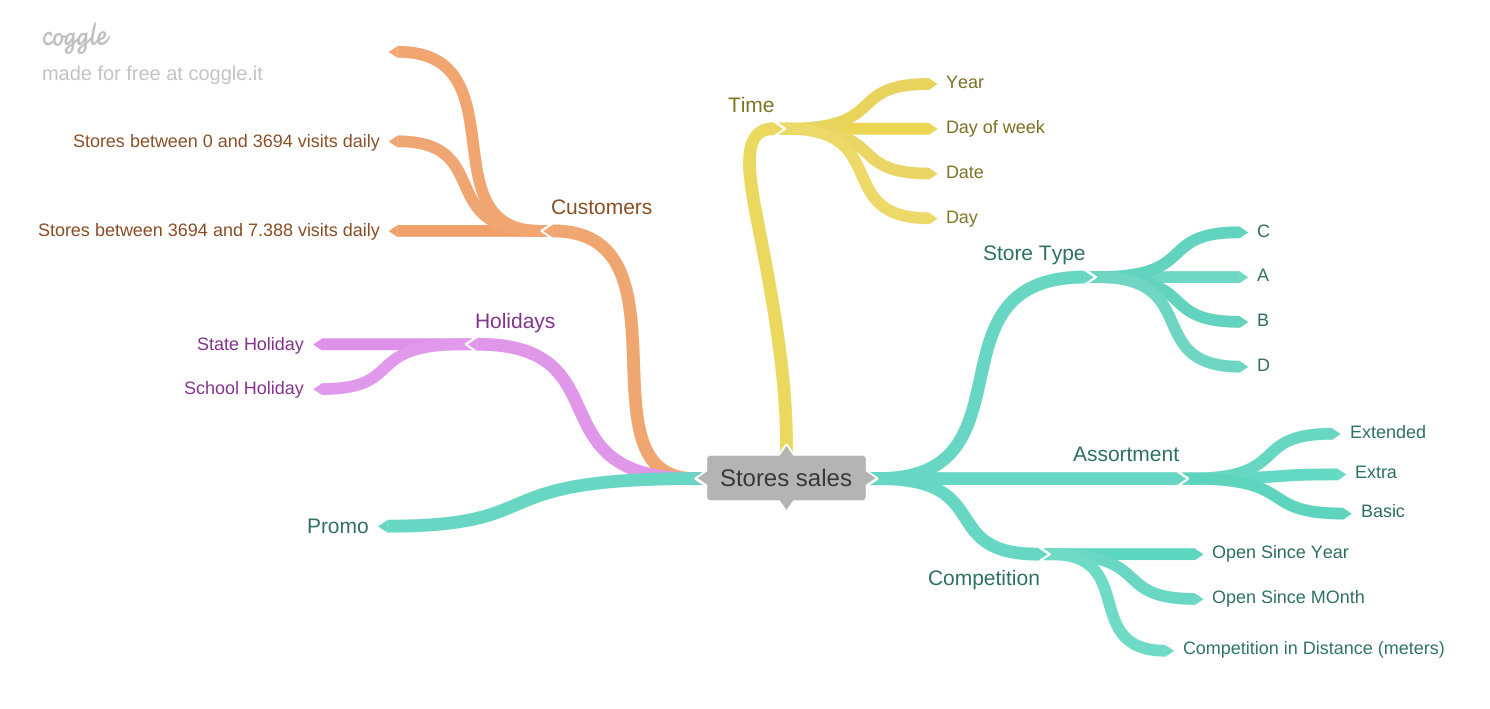

In [27]:
Image('../MindMapHipothesis.png')

## 2.3 Lista Final de Hipóteses

**H1** Lojas deveriam vender mais no inicio do ano. 

**H2** Lojas deveriam vender mais na segunda-feira.

**H3** Lojas deveriam vender mais ao longo dos anos.

**H4** Lojas com maior sortimento deveriam vender mais.

**H5** Lojas com competidores próximos deveriam vender menos.

**H6** Lojas com competidores maduros deveriam vender mais.

**H7** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H8** Lojas deveriam vender mais em dias de feriados públicos.

**H9** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H10** Lojas deveriam vender menos aos finais de semana.

## 2.4 Feature Engineering

In [28]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 
                                                       'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 
                                                             'easter_holiday' if x == 'b' else
                                                             'christmas' if x == 'c' else 'regular_day' )

# 3.0 FILTRAGEM DAS VARIÁVEIS

In [29]:
df3 = df2.copy()

## 3.1 Filtragem das Linha

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [32]:
df4 = df3.copy()

## 4.1 Análise Univariada

## 4.1.2 Variável Resposta

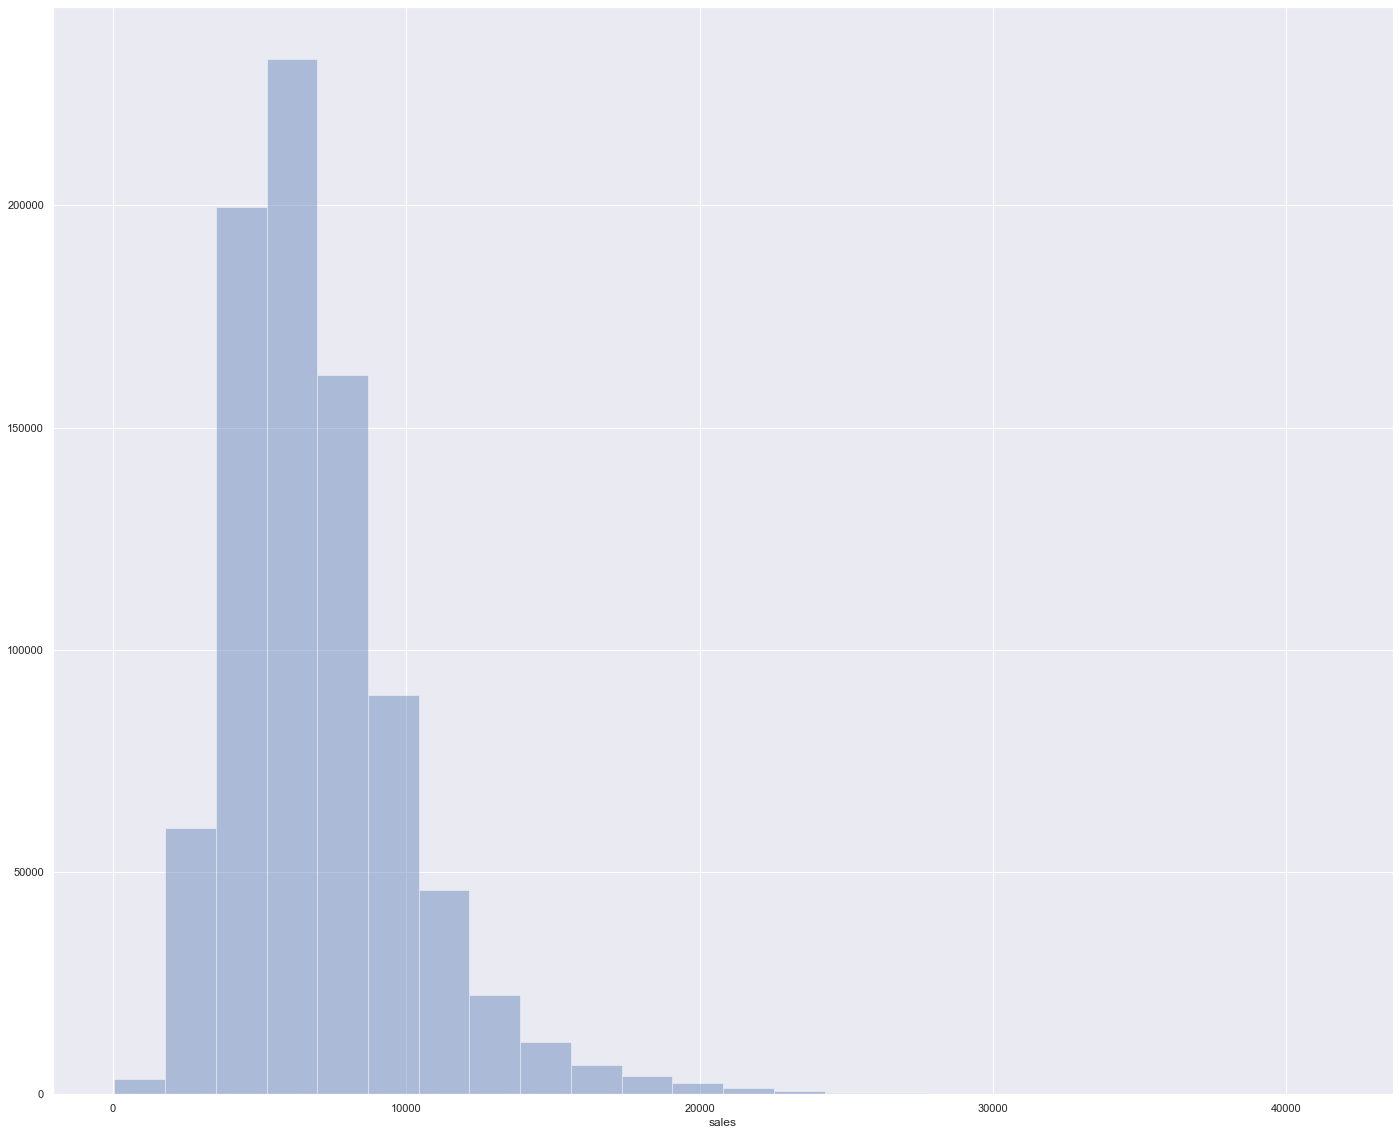

In [127]:
sns.distplot(df4['sales'] , bins=24, kde= False)

## 4.1.3 Variavéis Númericas

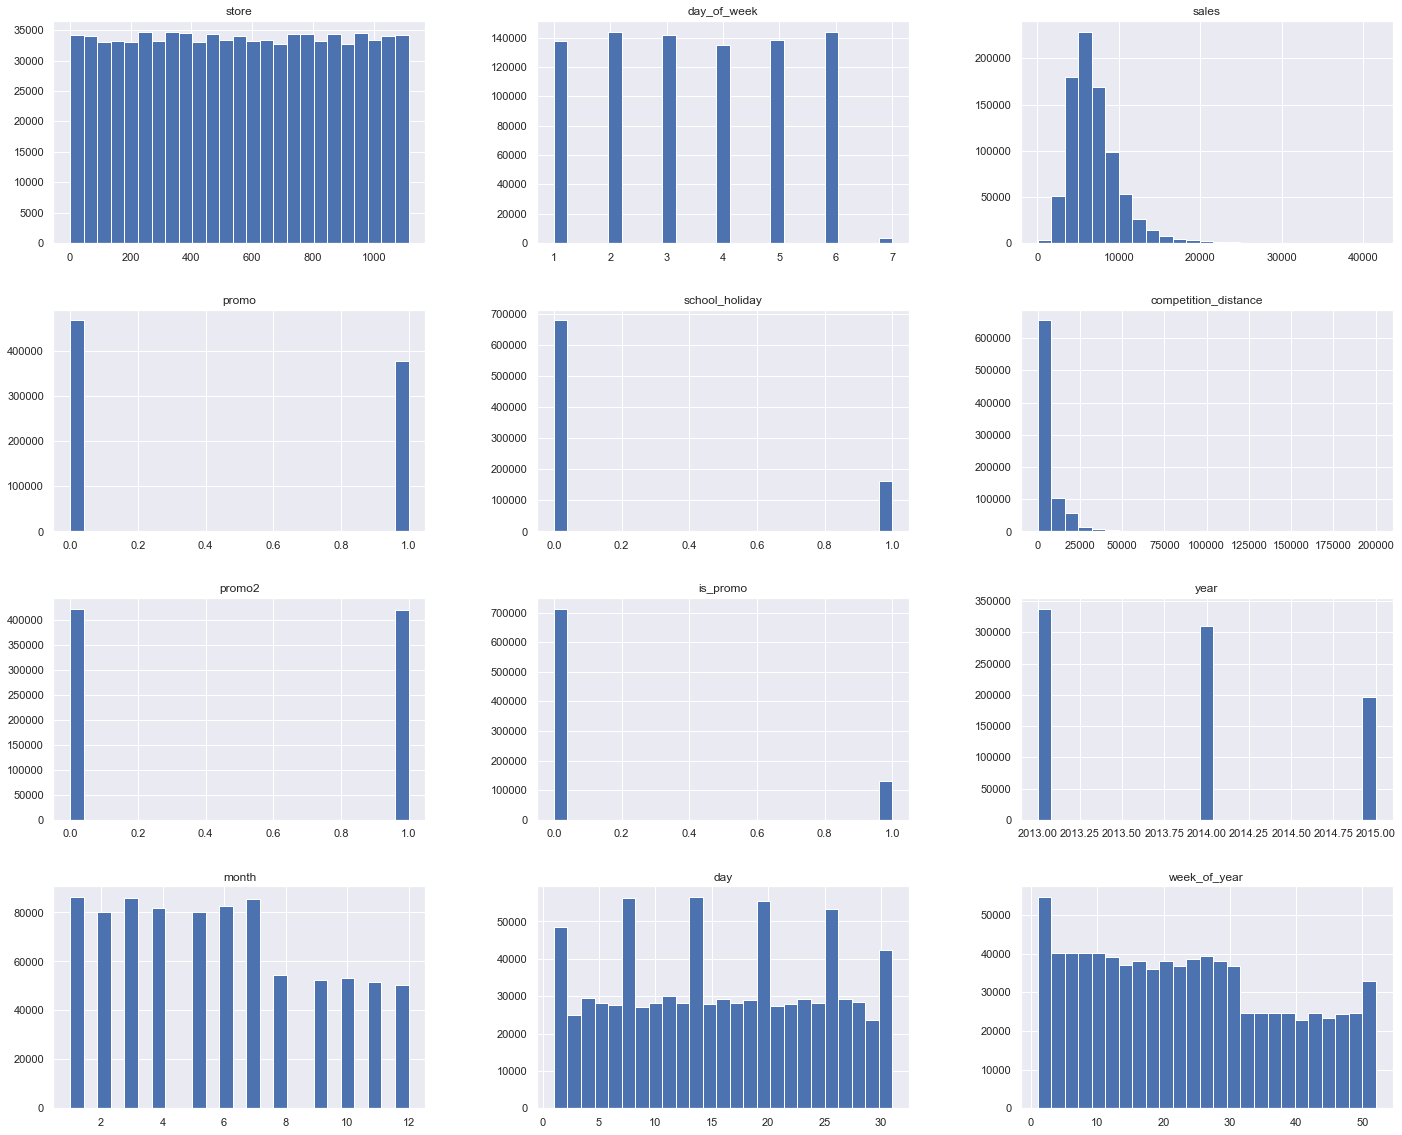

In [132]:
num_attributes.hist( bins=25 );

## 4.1.4 Variáveis Categóricas

<AxesSubplot:xlabel='sales', ylabel='Density'>

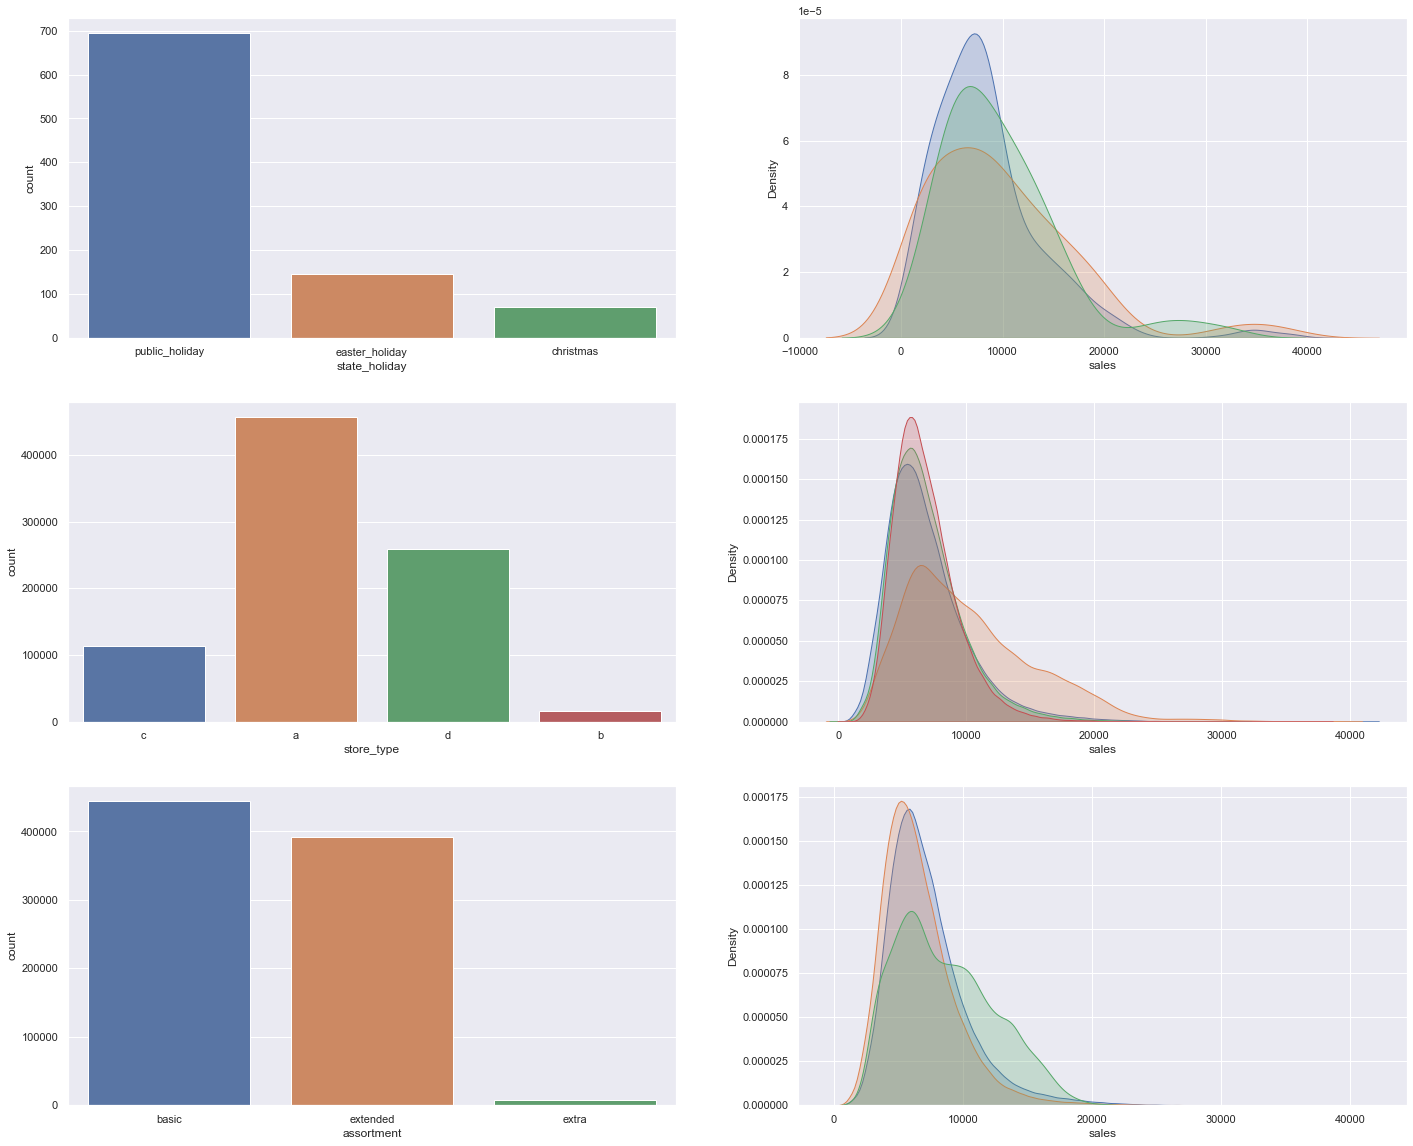

In [301]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day'] 
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2 Análise Bivariada

## **H1**. Lojas deveriam vender mais no inicio do ano. 
**VERDADEIRA**  Lojas vendem mais no inicio do ano. 

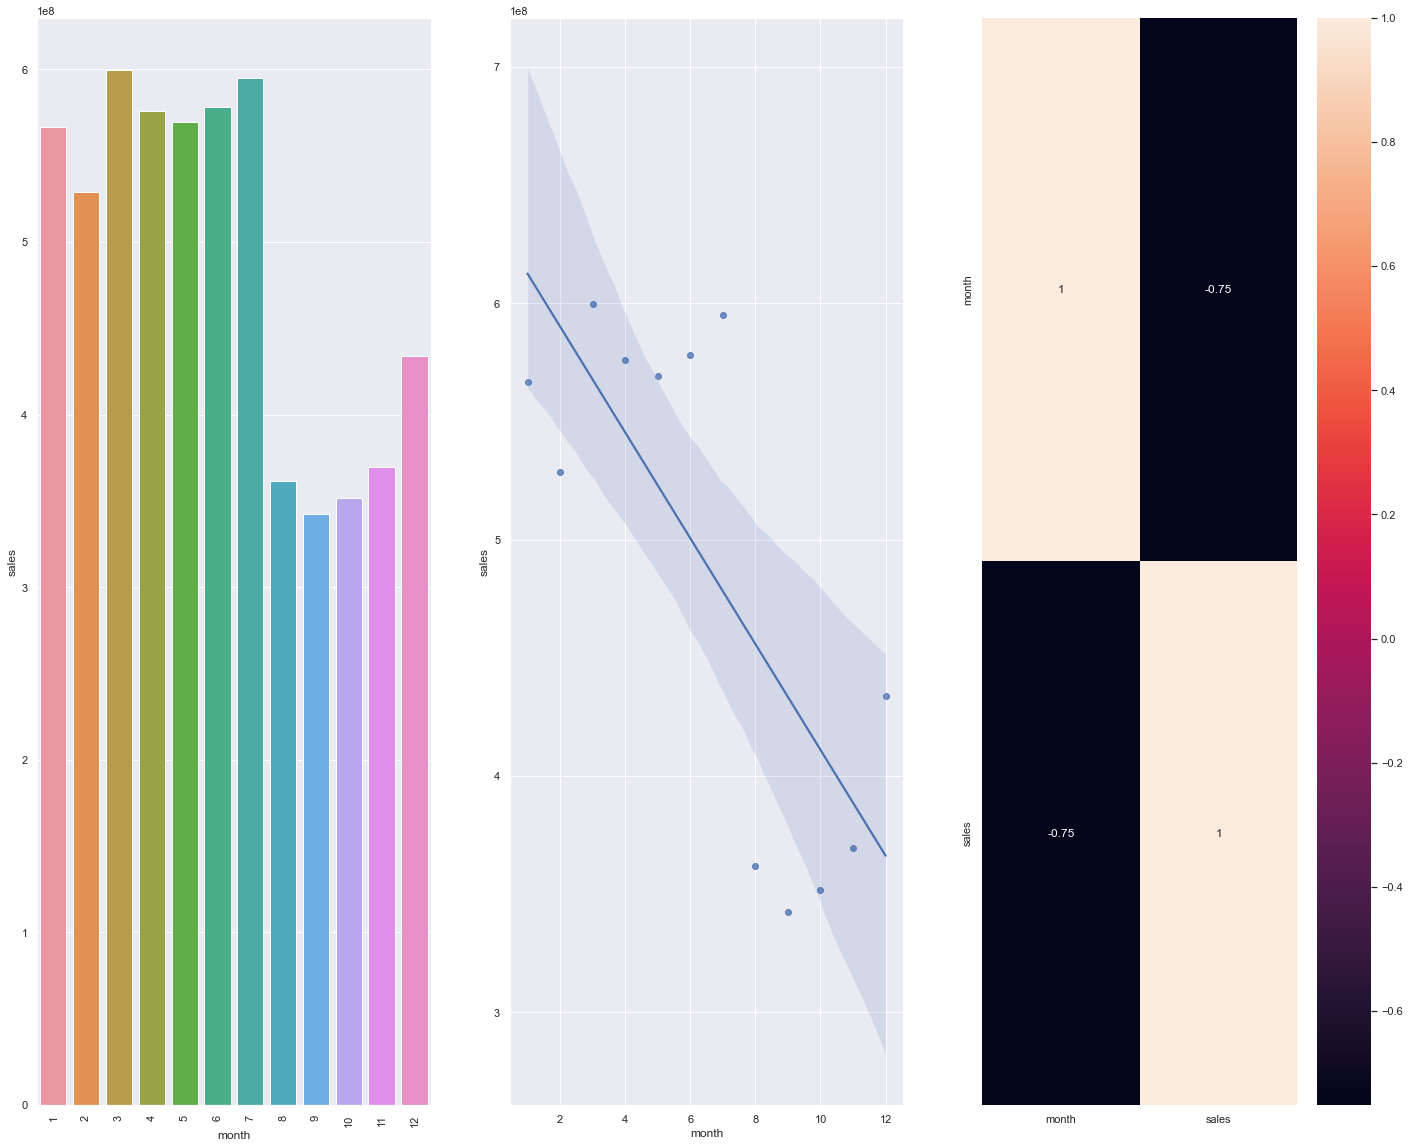

In [302]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
xticks(rotation=90)

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## **H2**. Lojas deveriam vender mais na segunda-feira.
**VERDADEIRA** Lojas vendem mais na segunda-feira.

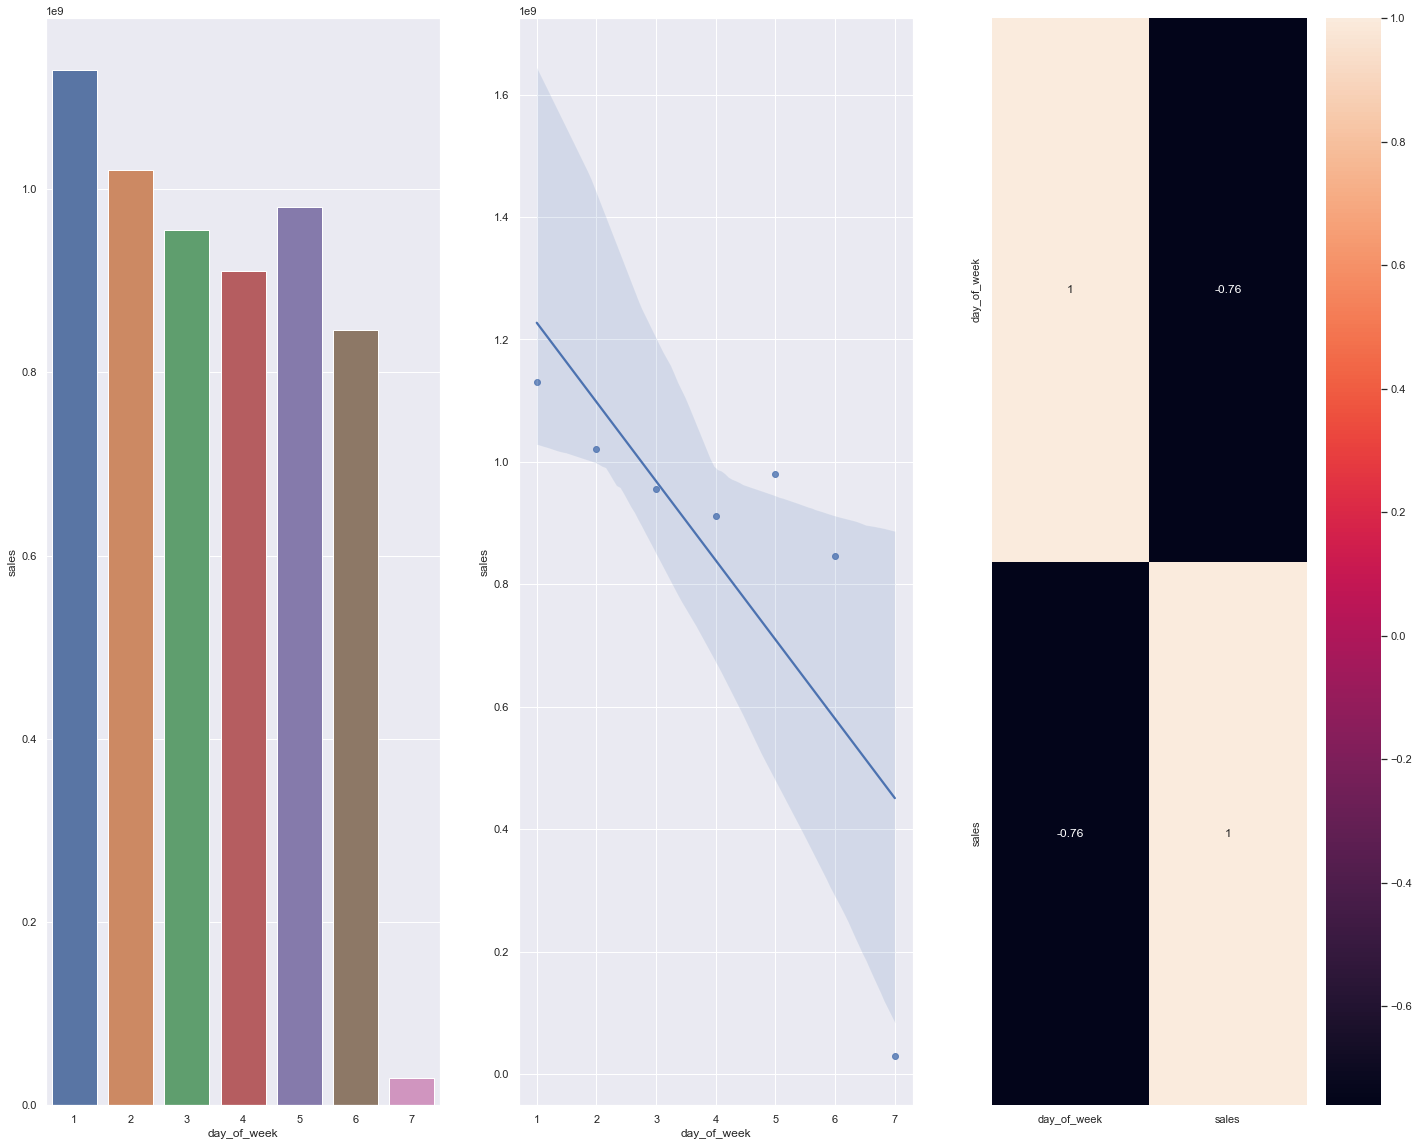

In [303]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## **H3**. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

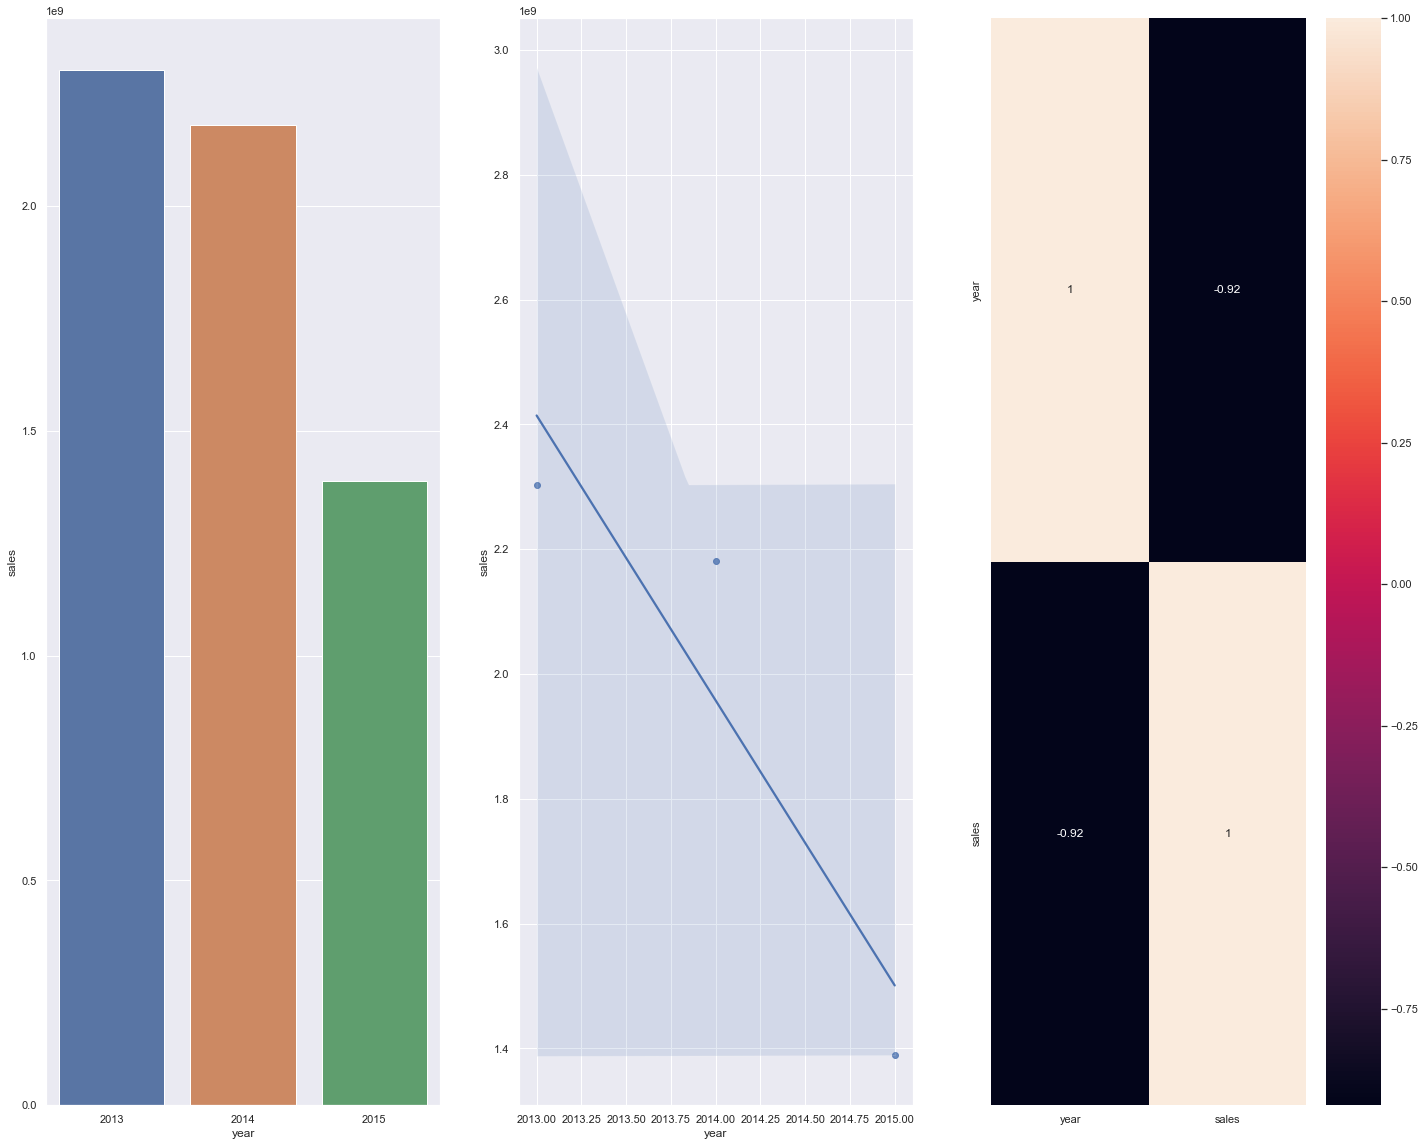

In [304]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index() 

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 ); 

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H4**. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

<AxesSubplot:xlabel='year_week'>

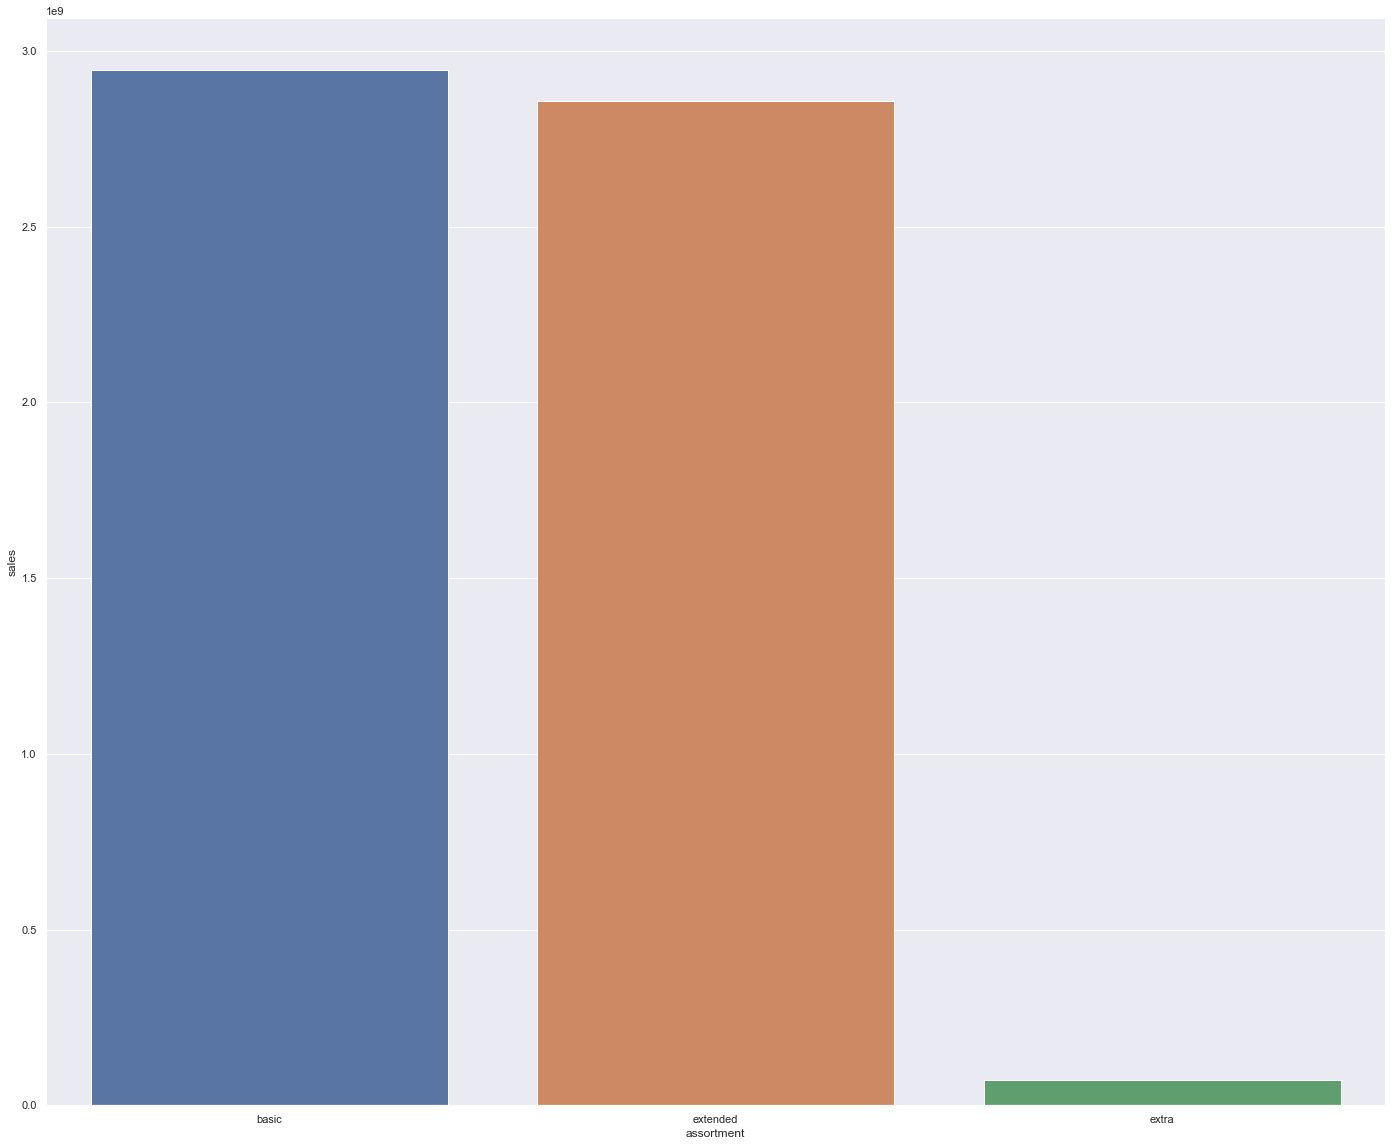

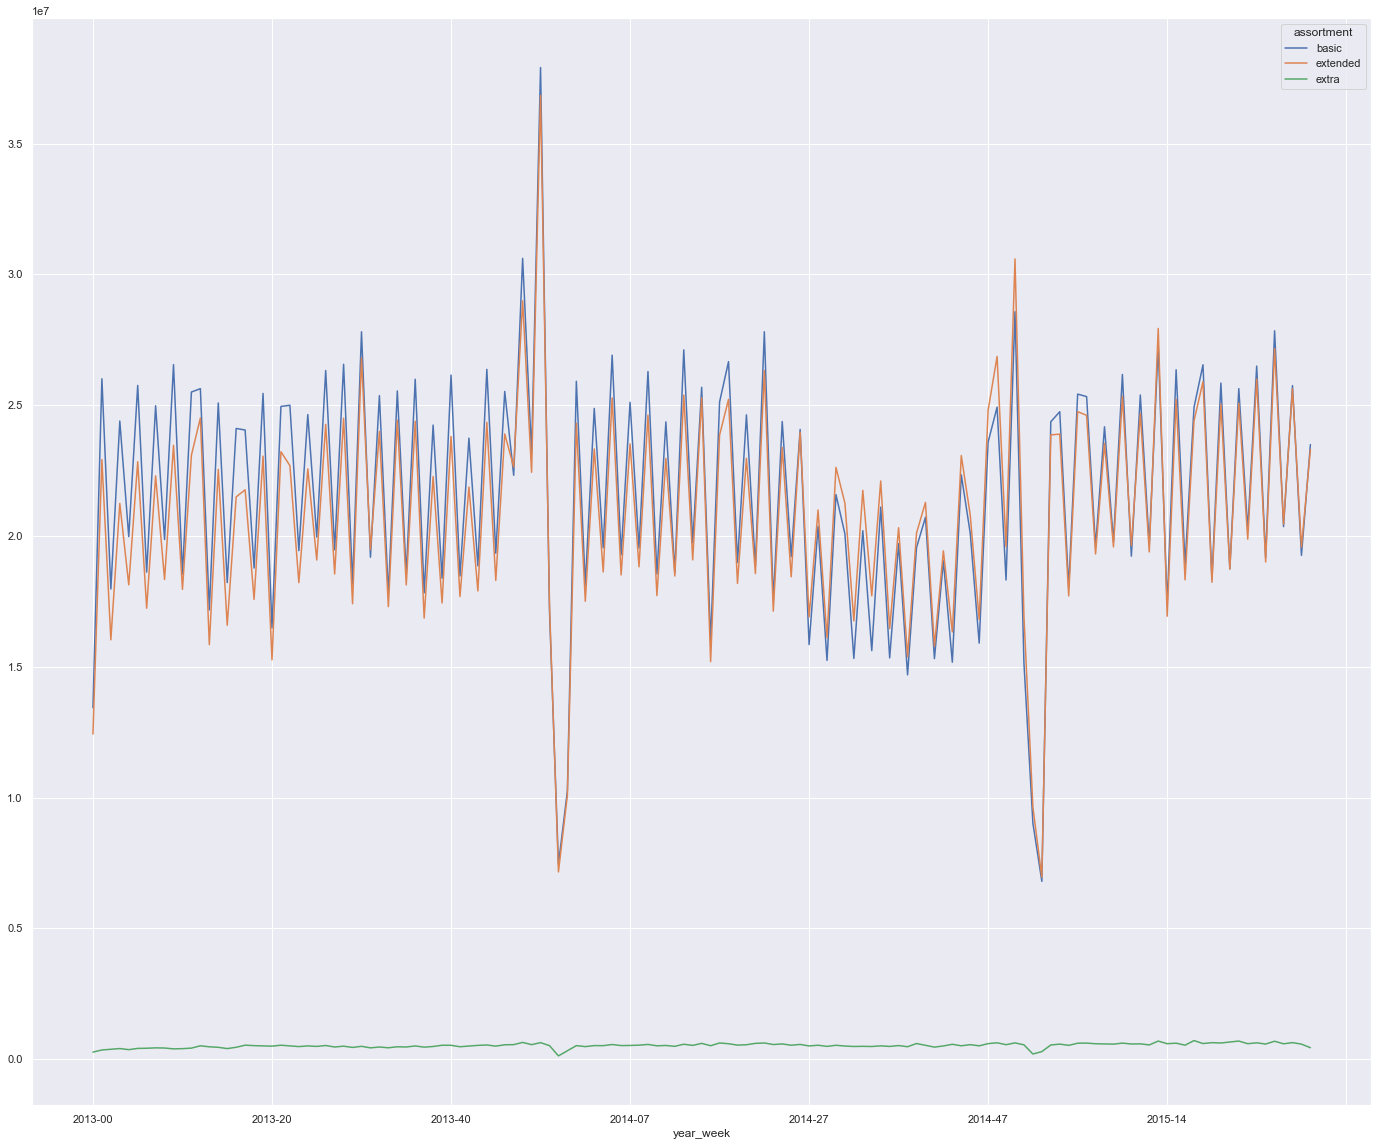

In [305]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

## **H5**. Lojas com competidores próximos deveriam vender menos.
**FALSA** Lojas com competidores próximo vendem mais.

<AxesSubplot:>

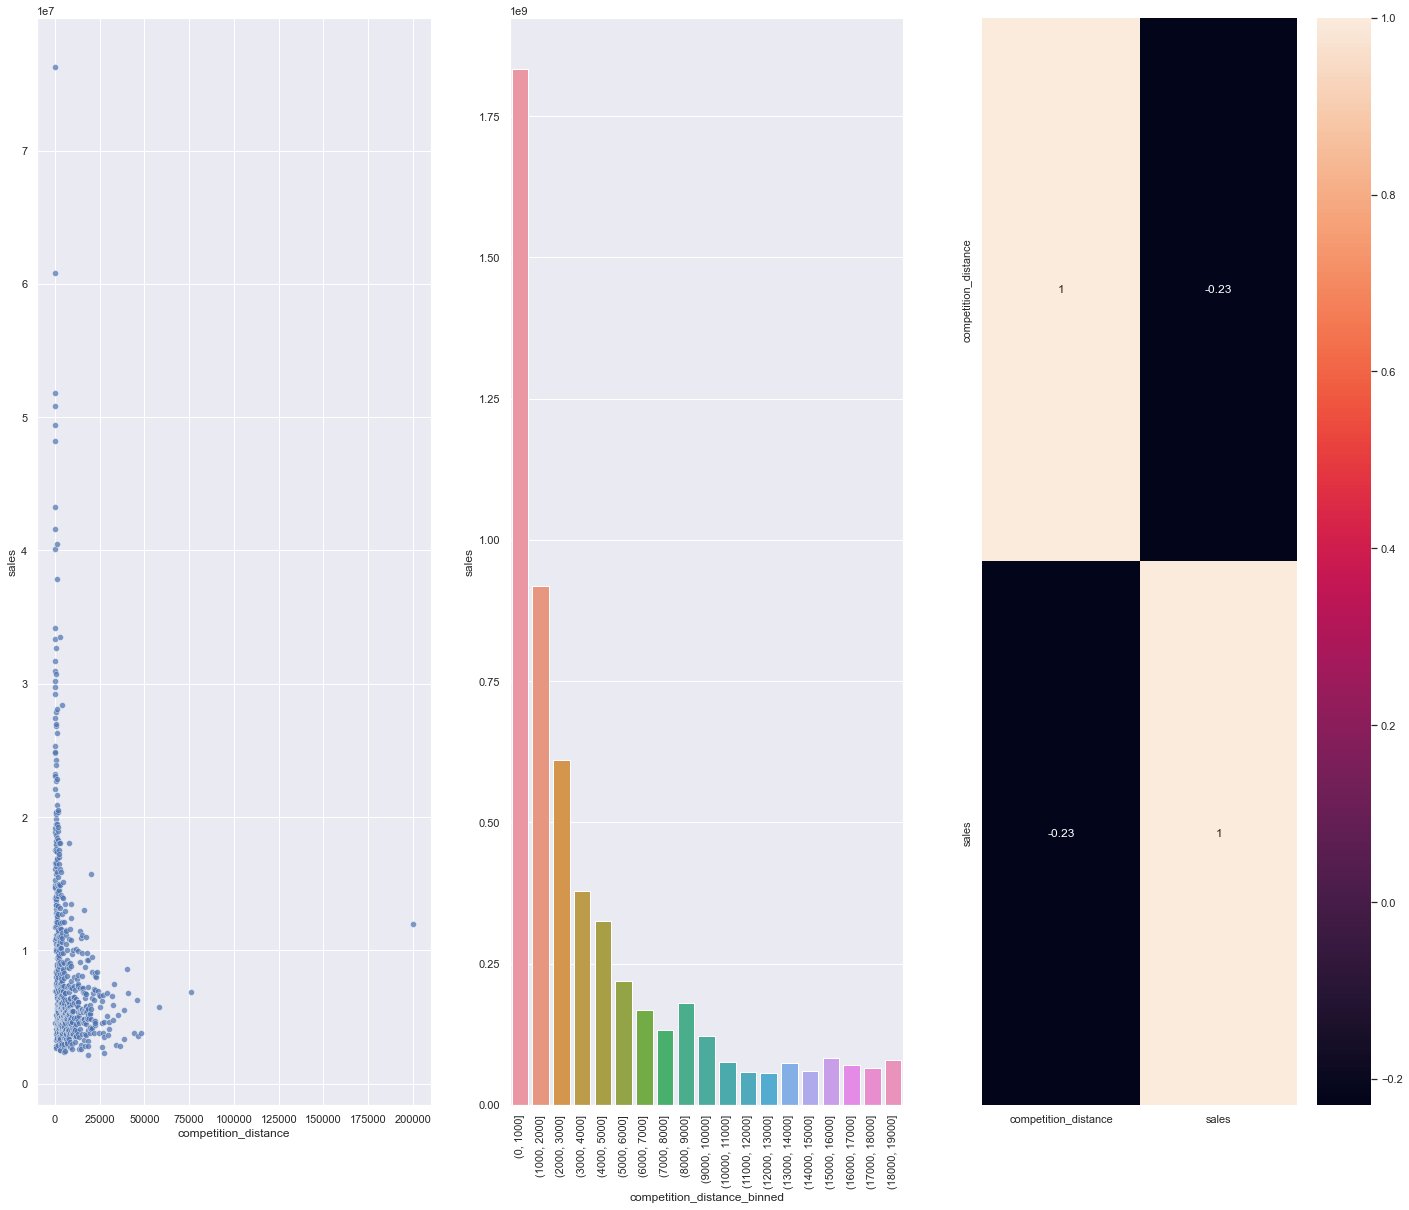

In [306]:
aux1 = df4[['competition_distance', 'sales']].groupby(['competition_distance']).sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(
    x='competition_distance',
    y='sales',
    data=aux1,
    alpha=0.7,
)
# plt.xscale('log')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

## **H6**. Lojas com competidores maduros deveriam vender mais.
**FALSA** Lojas com competidores maduros vendem menos.

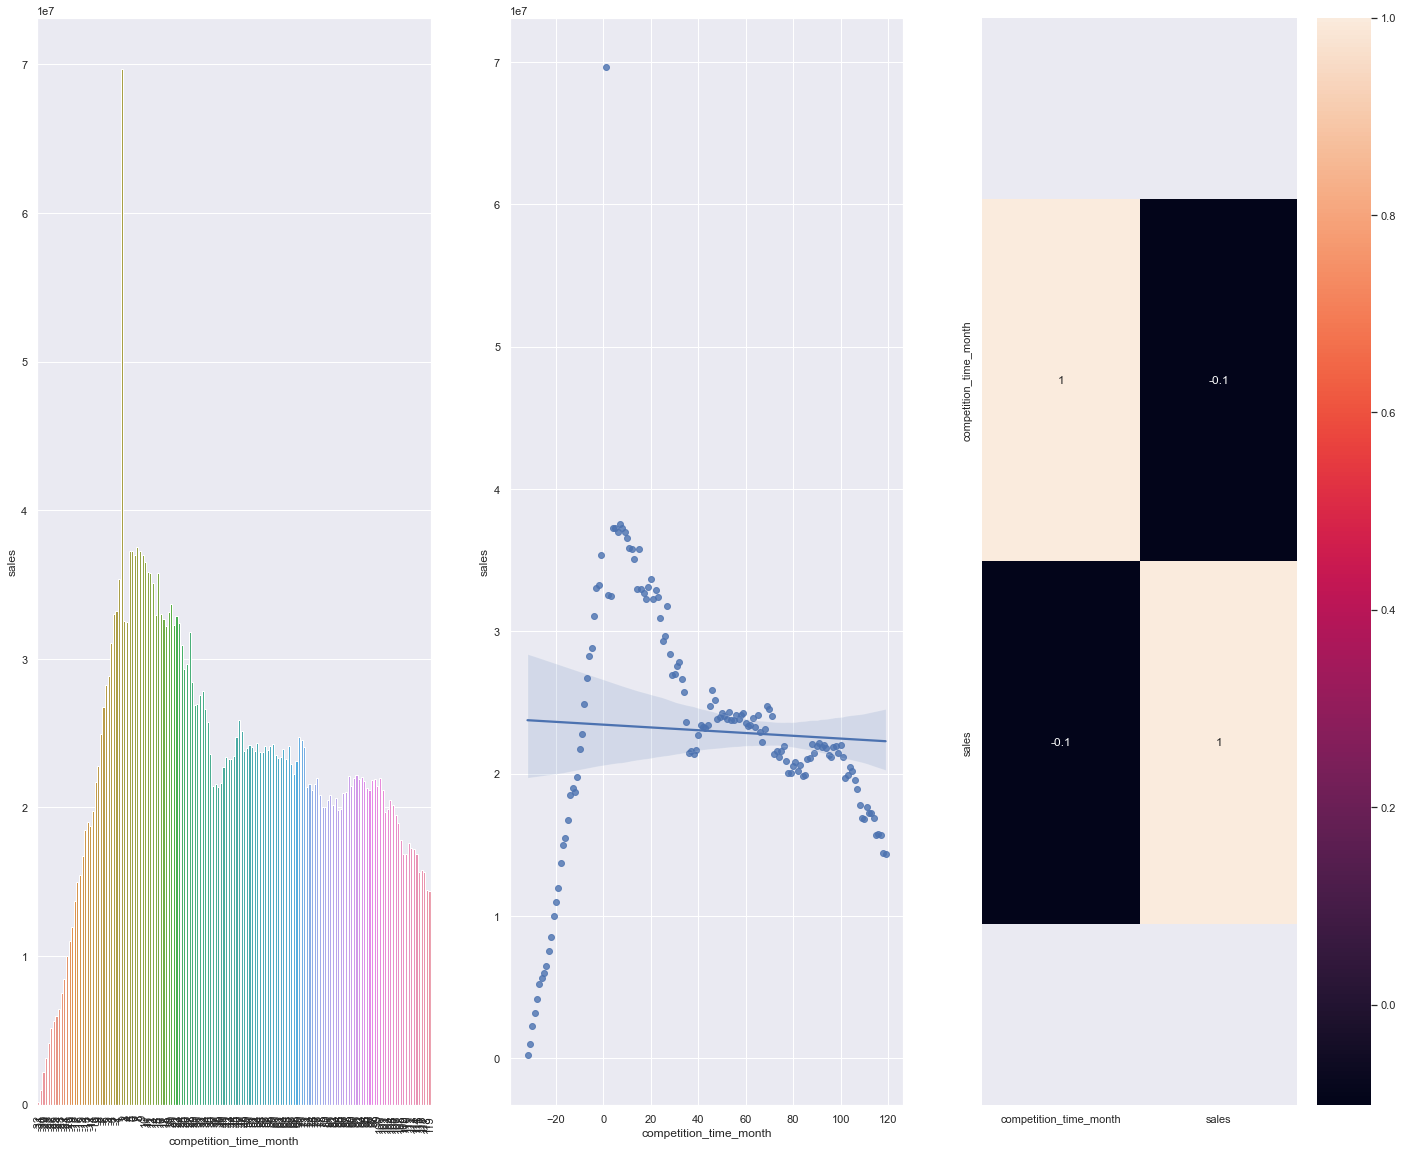

In [307]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 ); 

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

## **H7**. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês.

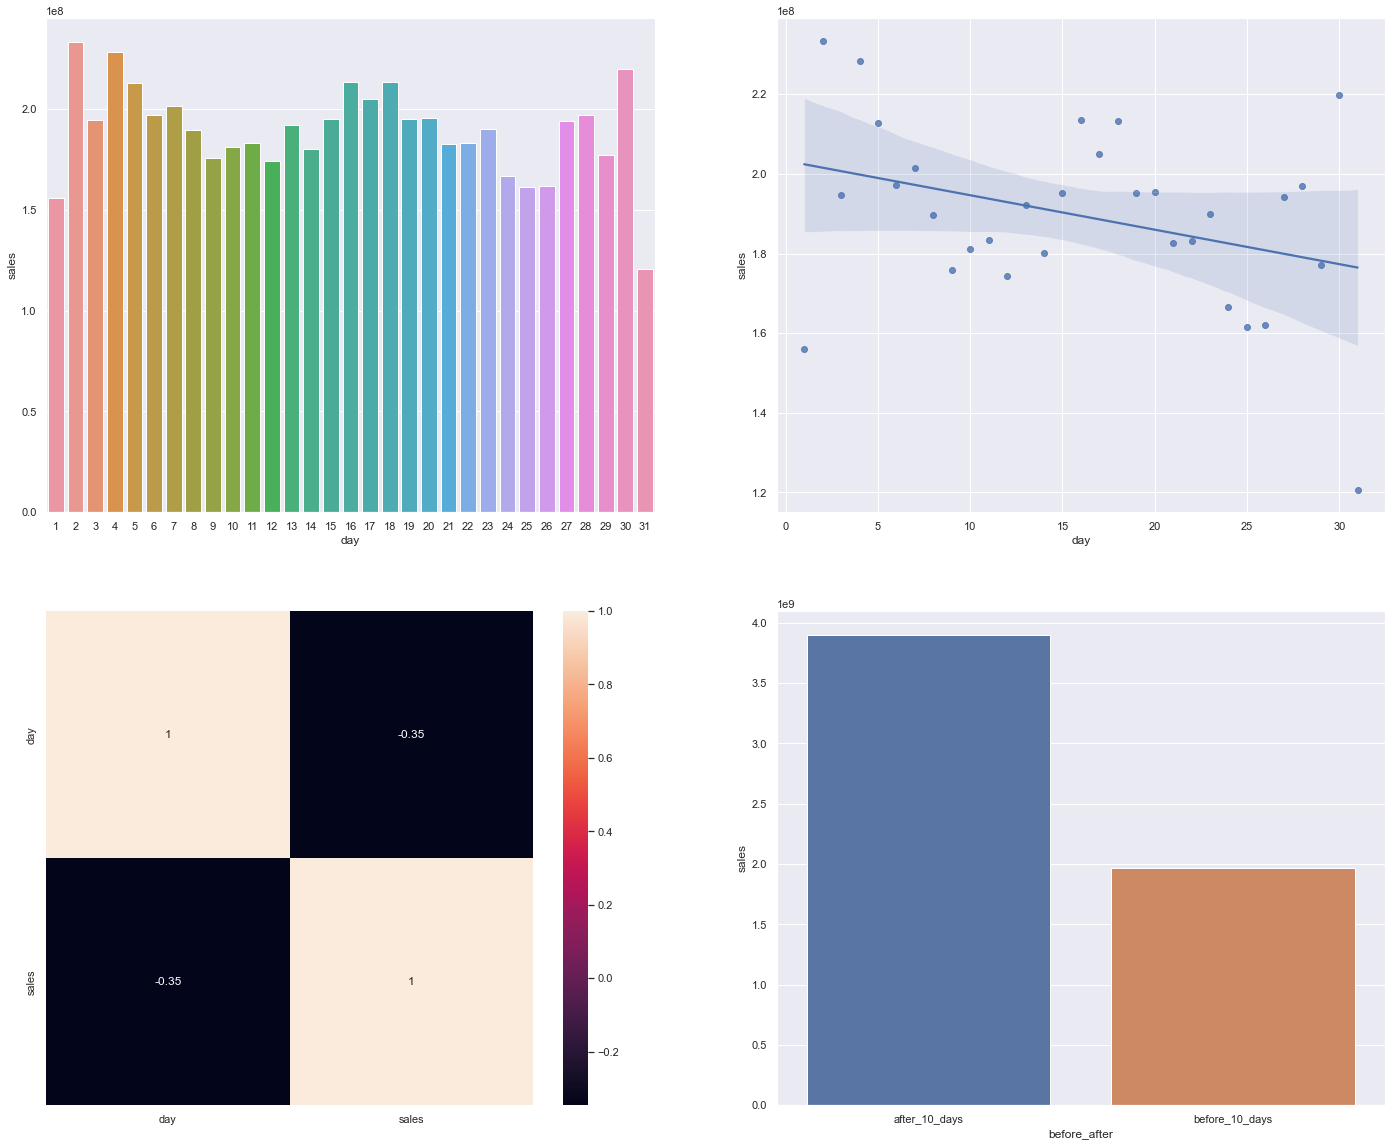

In [367]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

## **H8**.  Lojas deveriam vender mais em dias de feriados públicos.
**VERDADEIRA** Lojas vendem mais em feriados públicos.

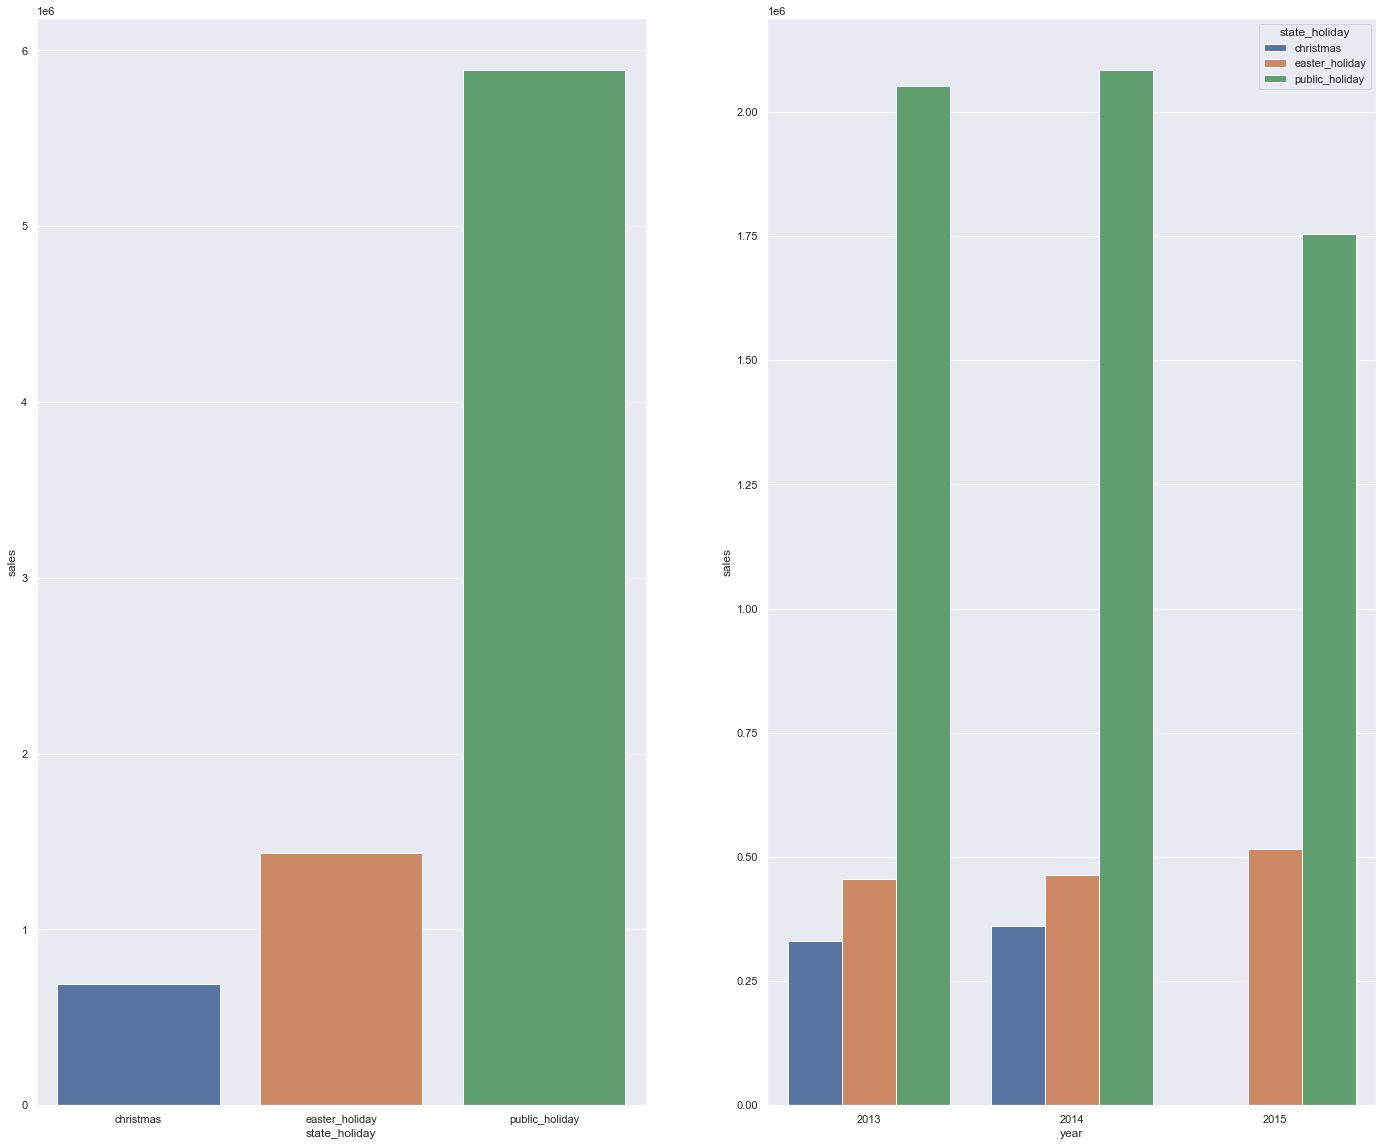

In [366]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

## **H9**.  Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de natal vendem menos.

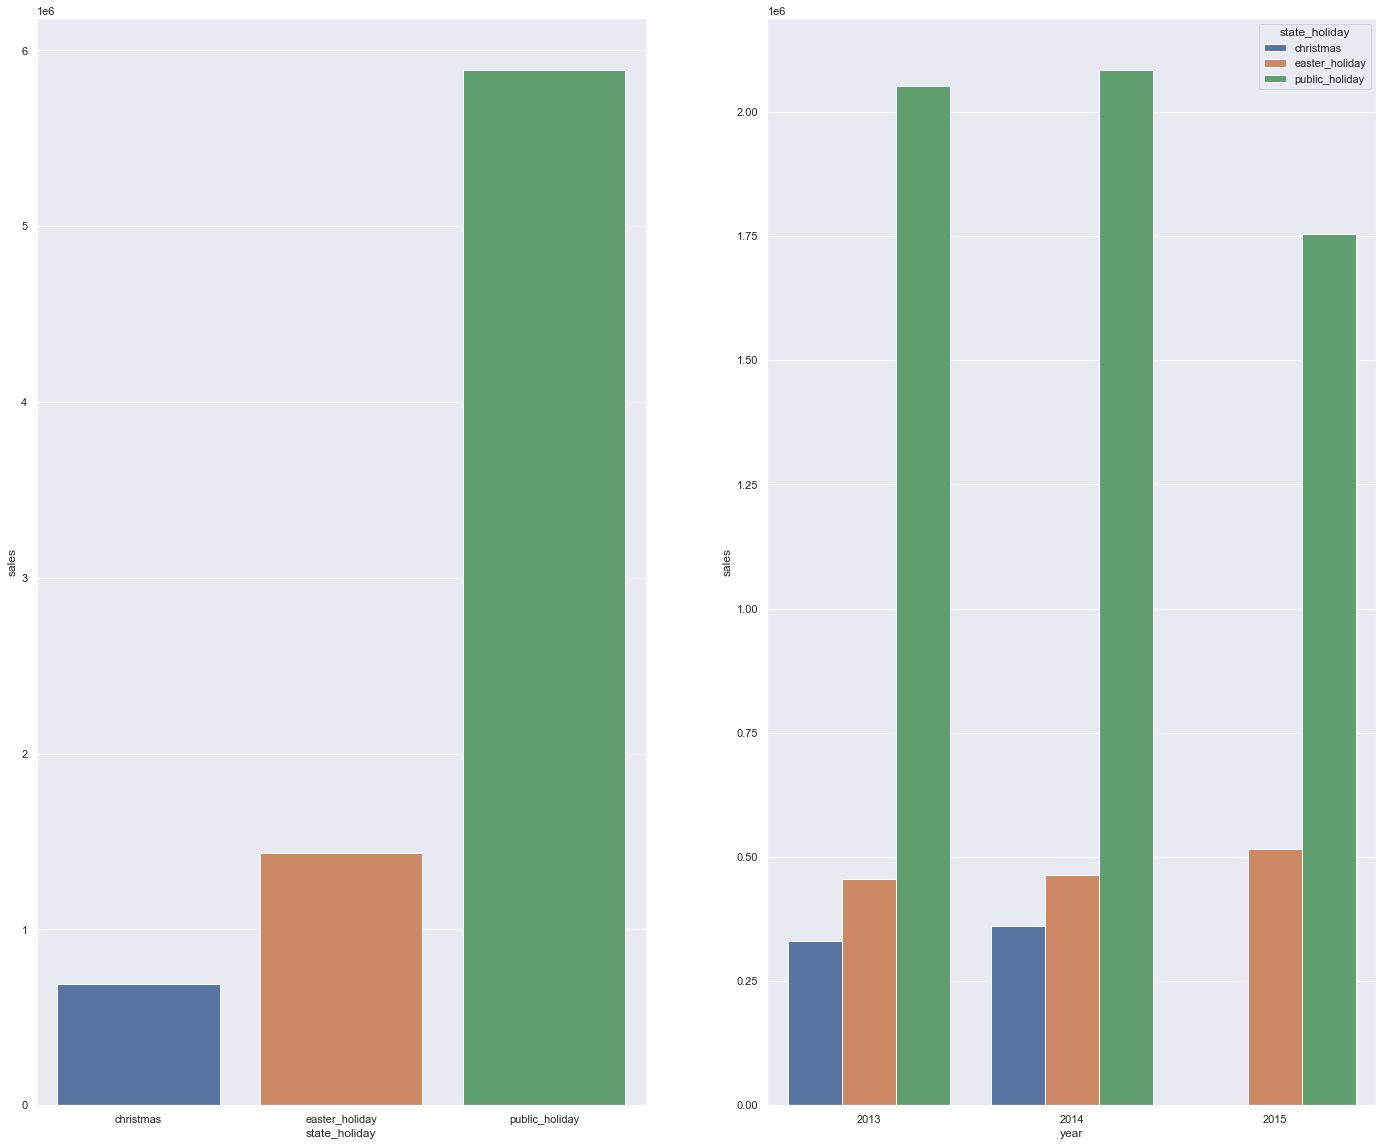

In [383]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

## H10. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana.

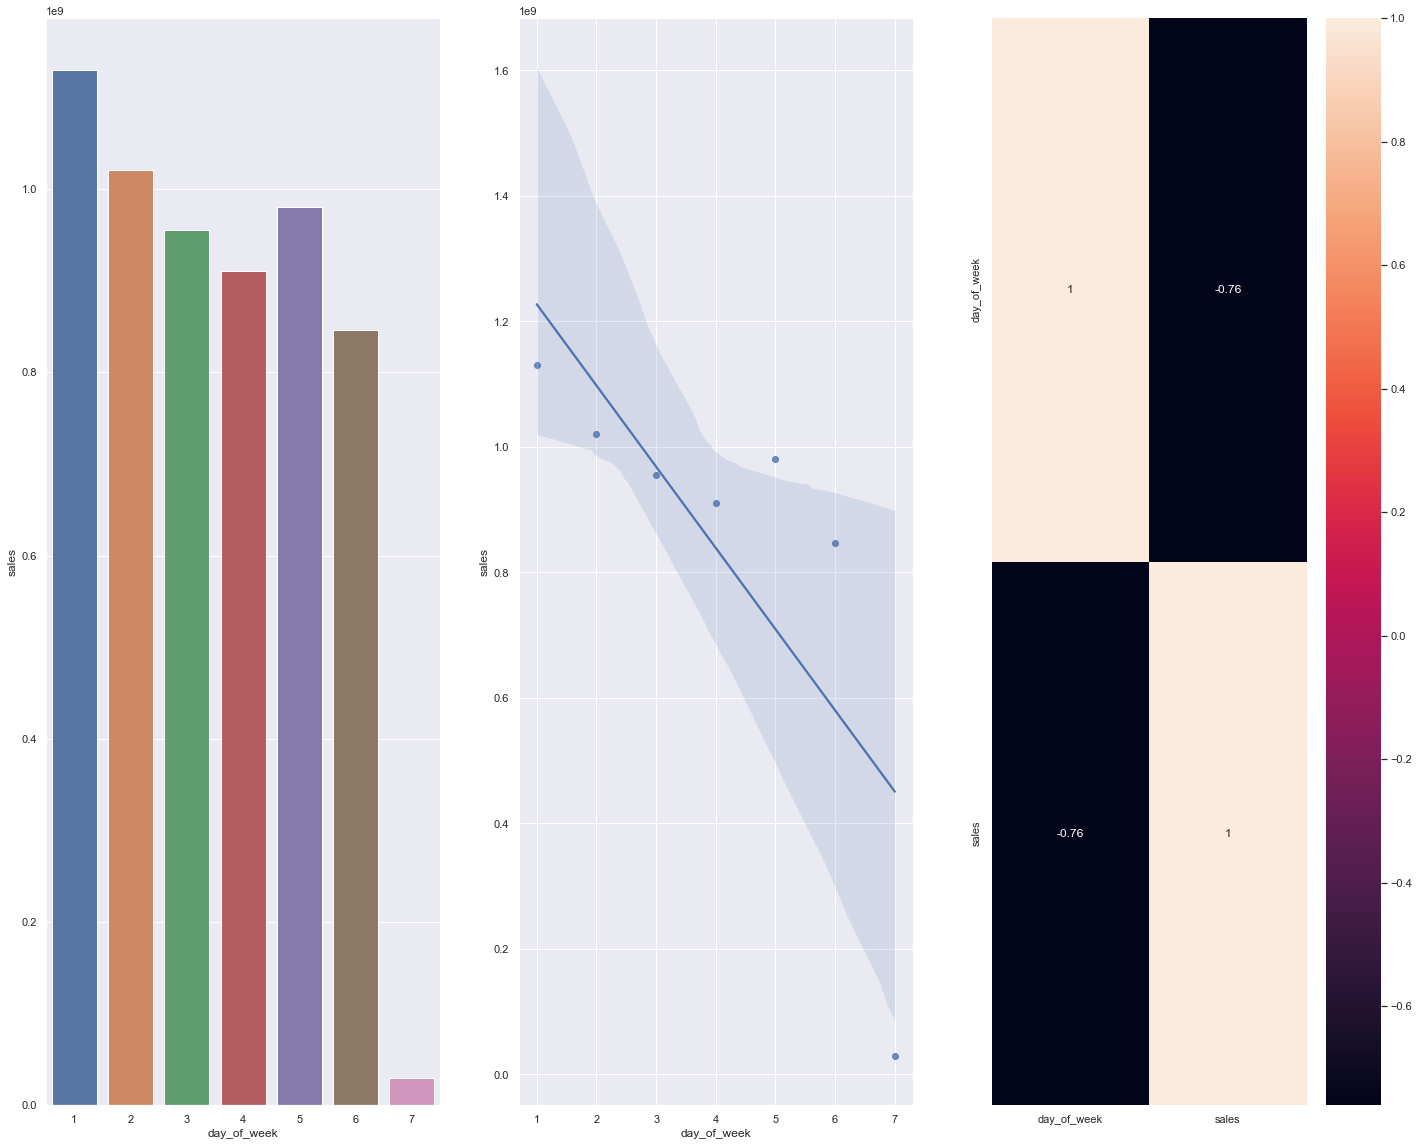

In [374]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 4.2.2 Resumo das Hipóteses

In [385]:
from tabulate import tabulate

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Alta'],
['H2', 'Verdadeira ', 'Alta'],
['H3', 'Falsa', 'Alta'],
['H4', 'Falsa', 'Baixa'],
['H5', 'Falsa', 'Alta'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Verdadeira', 'Baixa'],
['H8', 'Verdadeira', 'Baixa'],
['H9', 'Falsa', 'Baixa'],
['H10', 'Verdadeira', 'Alta'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Verdadeira   Alta
H3           Falsa        Alta
H4           Falsa        Baixa
H5           Falsa        Alta
H6           Falsa        Baixa
H7           Verdadeira   Baixa
H8           Verdadeira   Baixa
H9           Falsa        Baixa
H10          Verdadeira   Alta


## 4.3 Análise Multivariada

## 4.3.1 Atributos Númericos

<AxesSubplot:>

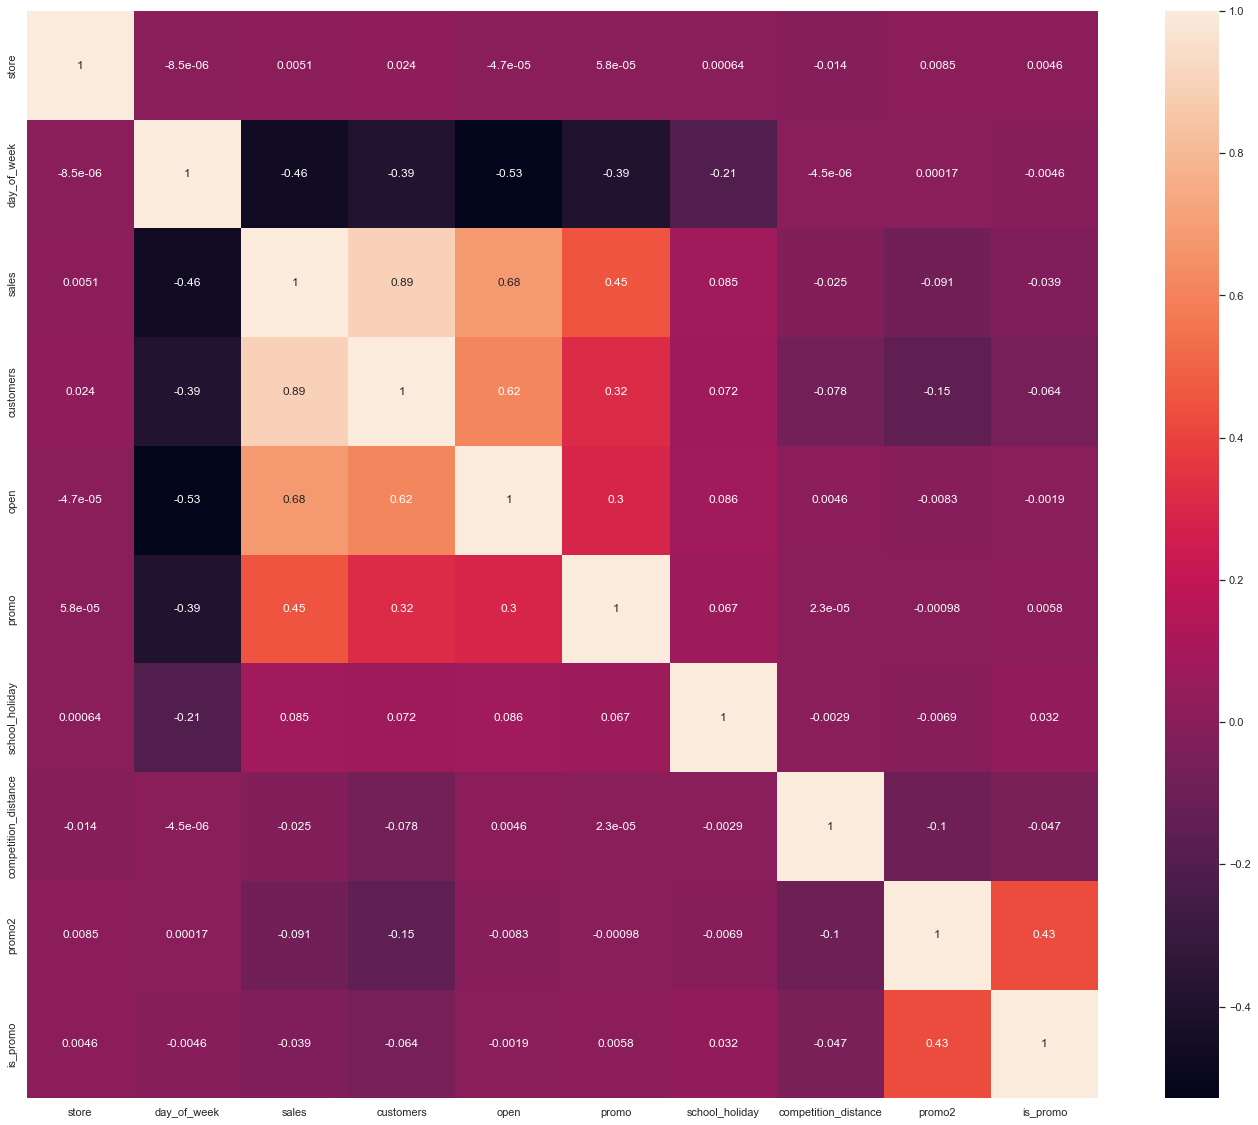

In [309]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

## 4.3.2 Atributos Categóricos

<AxesSubplot:>

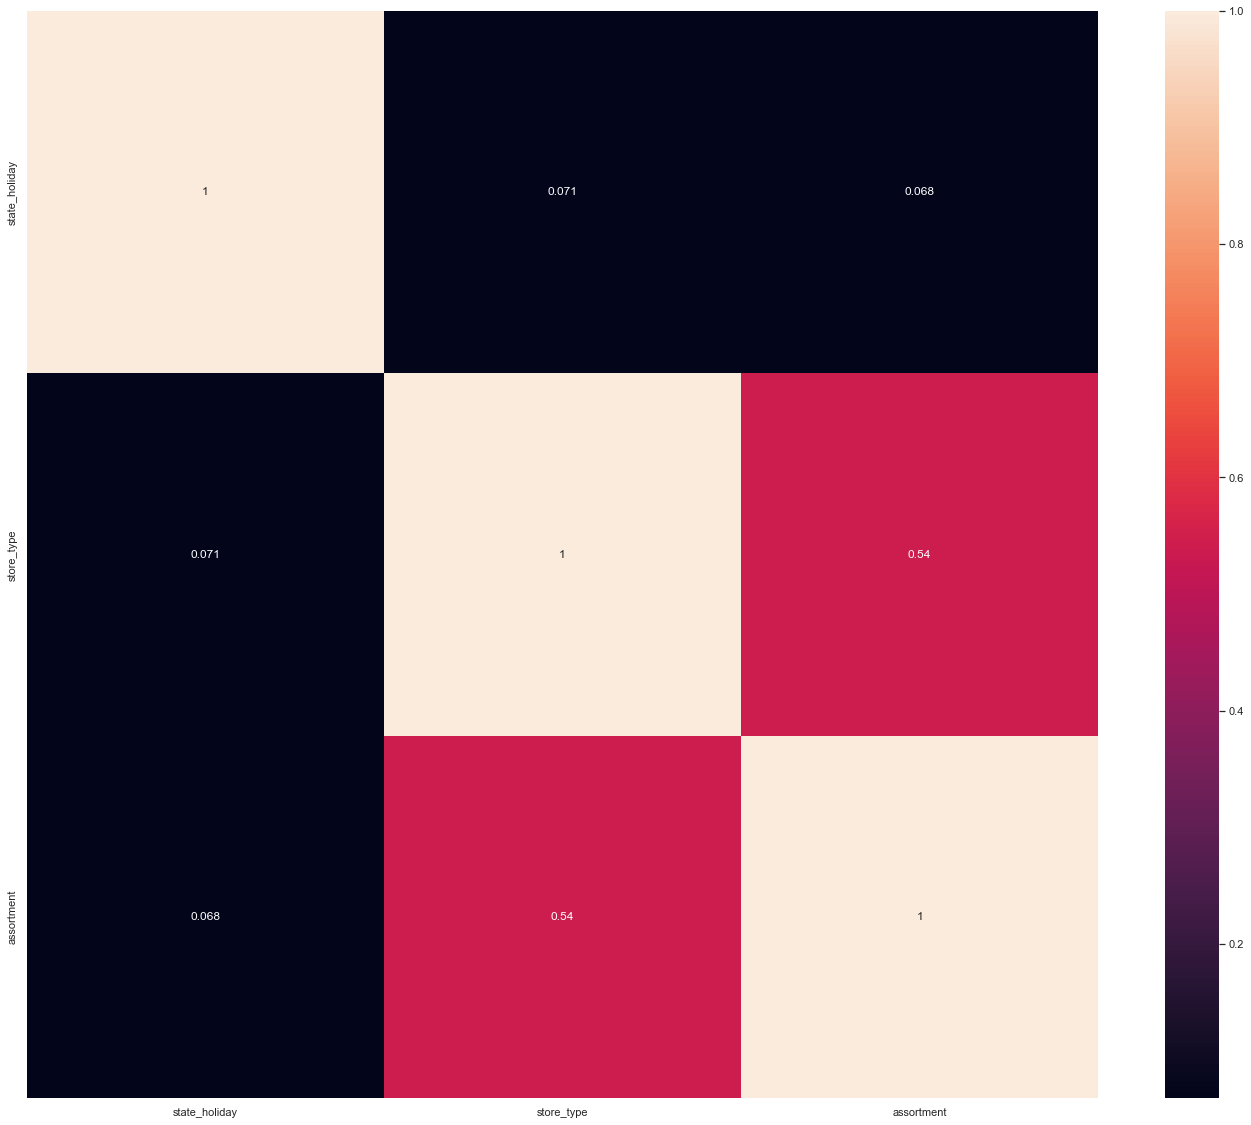

In [315]:
# only categorical data
a = df4.select_dtypes( include='object' ) 

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] ) 
a2 = cramer_v( a['state_holiday'], a['store_type'] ) 
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] ) 
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 PREPARAÇÃO DOS DADOS

In [120]:
df5 = df4.copy()

## 5.2 Scaling

In [121]:
scale = StandardScaler()

# competition distance
df5['competition_distance'] = scale.fit_transform( df5[['competition_distance']].values )
#pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = scale.fit_transform(df5[['competition_time_month']].values )
#pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = scale.fit_transform( df5[['promo_time_week']].values )
#pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = scale.fit_transform( df5[['year']].values )
#pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3 Transformação

## 5.3.1 Encoding

In [122]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
#pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

## 5.3.2 Responsable Variable Transformation

In [123]:
df5['sales'] = np.log1p(df5['sales'] )

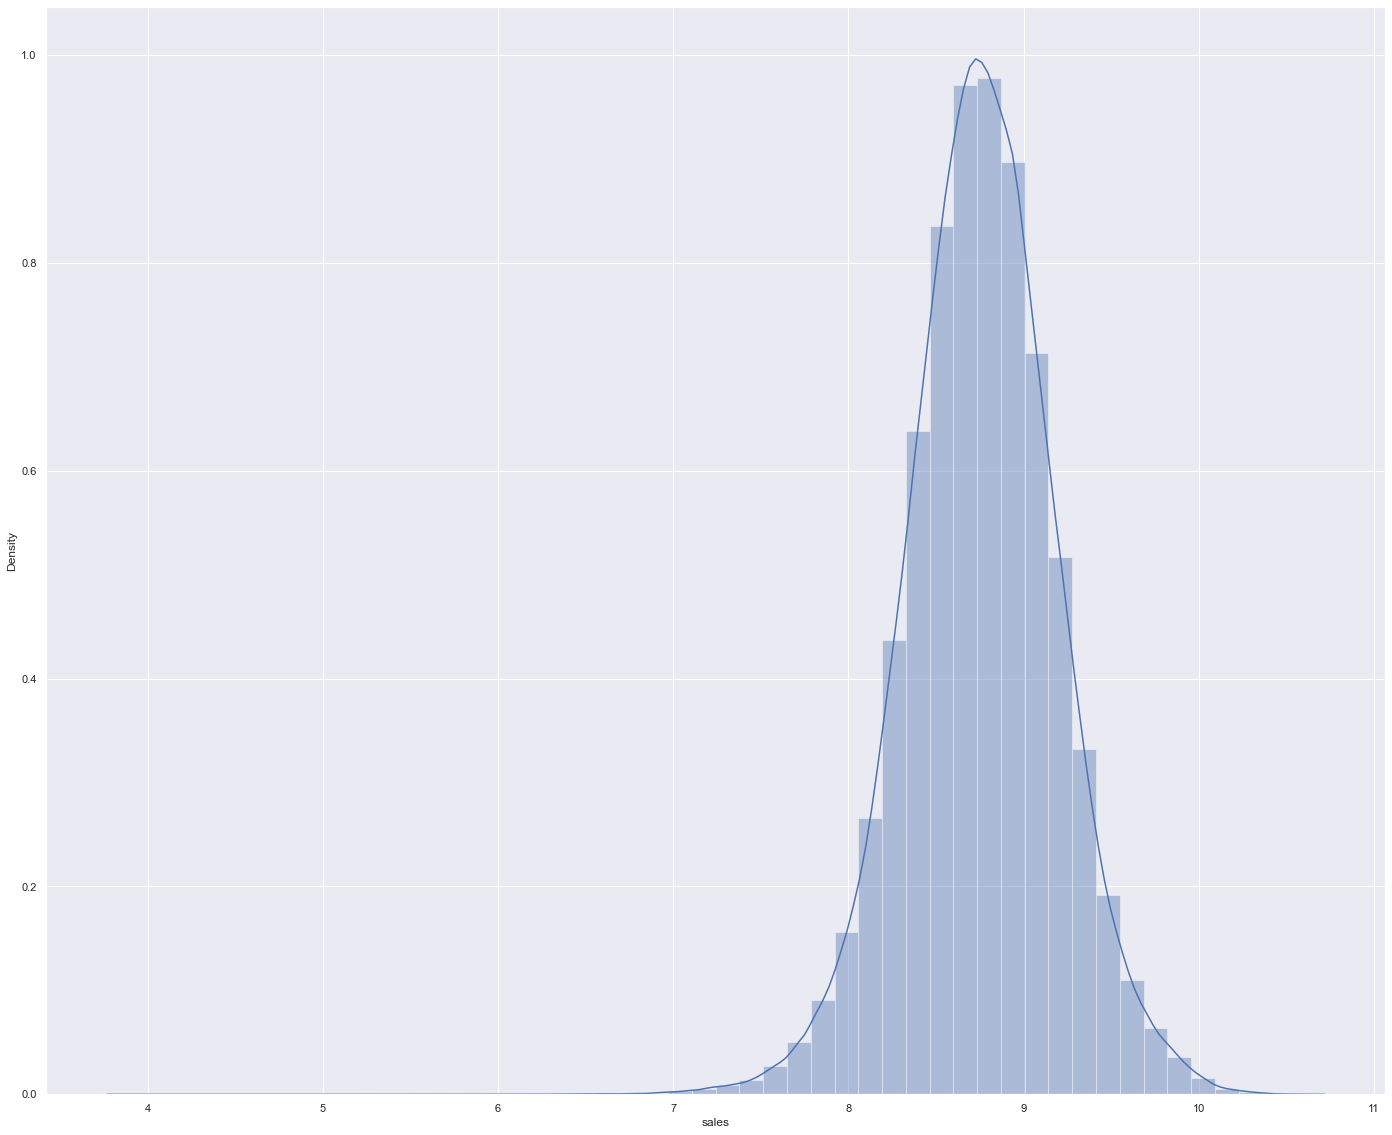

In [124]:
sns.distplot(df5['sales']) 

# 6.0 FEATURE SELECTION

In [125]:
df6 = df5.copy()

## 6.1 Split dataframe into train and test

In [126]:
cols_drop = ['promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [127]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00


## 6.2 Boruta as Feature Selector

In [128]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

In [129]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [130]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week']
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [131]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [48]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.413001,1835.135542


## 7.2 Linear Regressor 

In [49]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1909.742755,0.304188,2705.624631


In [50]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2107.49 +- 317.92,0.3 +- 0.01,3005.6 +- 490.76


## 7.3 Linear Regressor Regularized - Lasso

In [51]:
 # model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1909.470249,0.291887,2767.956947


## 7.3.1 Linear Regressor Regularized - Lasso - Cross Validation

In [52]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2133.71 +- 340.95,0.29 +- 0.01,3082.03 +- 502.85


## 7.4 XGBoost Regressor

In [59]:
 import xgboost as xgb

# model
xgboost = xgb.XGBRegressor(verbosity=0, random_state=42).fit( x_train, y_train )

# prediction
yhat_xgb = xgboost.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1027.801303,0.157887,1459.205472


## XGBoost Regressor - Cross Validation

In [66]:
xgb_result_cv = cross_validation( x_training, 5, 'XGB', xgboost, verbose=False )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGB,1251.65 +- 229.05,0.18 +- 0.02,1743.97 +- 344.28


## 7.4 Compare Model’s Performance

## 7.4.1. Single Performance

In [68]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1027.801303,0.157887,1459.205472
0,Average Model,1354.800353,0.413001,1835.135542
0,Linear Regression,1909.742755,0.304188,2705.624631
0,Linear Regression - Lasso,1909.470249,0.291887,2767.956947


## 7.4.2 Real Performance - Cross Validation

In [71]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, xgb_result_cv] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1027.801303,0.157887,1459.205472
0,Average Model,1354.800353,0.413001,1835.135542
0,Linear Regression,1909.742755,0.304188,2705.624631
0,Linear Regression - Lasso,1909.470249,0.291887,2767.956947


## 8.0 HYPER PARAMETERS FINE TUNING

## 8.1 Random Search CV

In [73]:
#n_estimators = [100, 200, 300, 500]
#
#max_depth = [3, 5, 10, None]
#
#min_samples_leaf = [1, 2, 4]
#
#min_samples_split = [1, 2, 4]
#
#max_features = ['auto', 'sqrt']
#
#
## creating random grid
#
#params = {
#    'n_estimators': n_estimators,
#    'max_depth': max_depth,
#    'min_samples_leaf': min_samples_leaf,
#    'min_samples_split': min_samples_split,
#    'max_features': max_features,
#         }

In [74]:
#random_search = RandomizedSearchCV(estimator=xgboost,
#                                  param_distributions=params, 
#                                  n_iter=2,
#                                  n_jobs=-1, 
#                                  cv=5, 
#                                  verbose=2,
#                                  random_state=42)
#
#random_search.fit( x_train, y_train)
#random_search.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5}

In [75]:
#params_tuned = {'n_estimators': 300,
# 'min_samples_split': 2,
# 'min_samples_leaf': 4,
# 'max_features': 'auto',
# 'max_depth': 5}

## 8.2 Final Model

In [132]:
# model
xgboost_tuned = xgb.XGBRegressor(n_estimators=300,
                                min_samples_split=2,
                                min_samples_leaf=4,
                                max_features='auto',
                                max_depth=5).fit( x_train, y_train)

# predict
yhat_xgb_tuned = xgboost_tuned.predict( x_test )

# result
xgb_tuned_result = ml_error('XGB',  y_test, yhat_xgb_tuned)
xgb_tuned_result

,Model Name,MAE,MAPE,RMSE
0,XGB,0.14086,0.016261,0.187282


In [ ]:
import pickle

filename = '../models/model_tuned.pkl'
model = pickle.dump(xgb_tuned, open(filename, 'wb'))

# 9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO

In [80]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [81]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [82]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,110631.390625,106983.802580,114278.978670,3647.588045,0.654391
875,876,192063.781250,186963.504203,197164.058297,5100.277047,0.494741
908,909,238008.671875,230744.228622,245273.115128,7264.443253,0.482808
482,483,190316.421875,189170.989377,191461.854373,1145.432498,0.397498
197,198,110764.734375,110035.227862,111494.240888,729.506513,0.396977


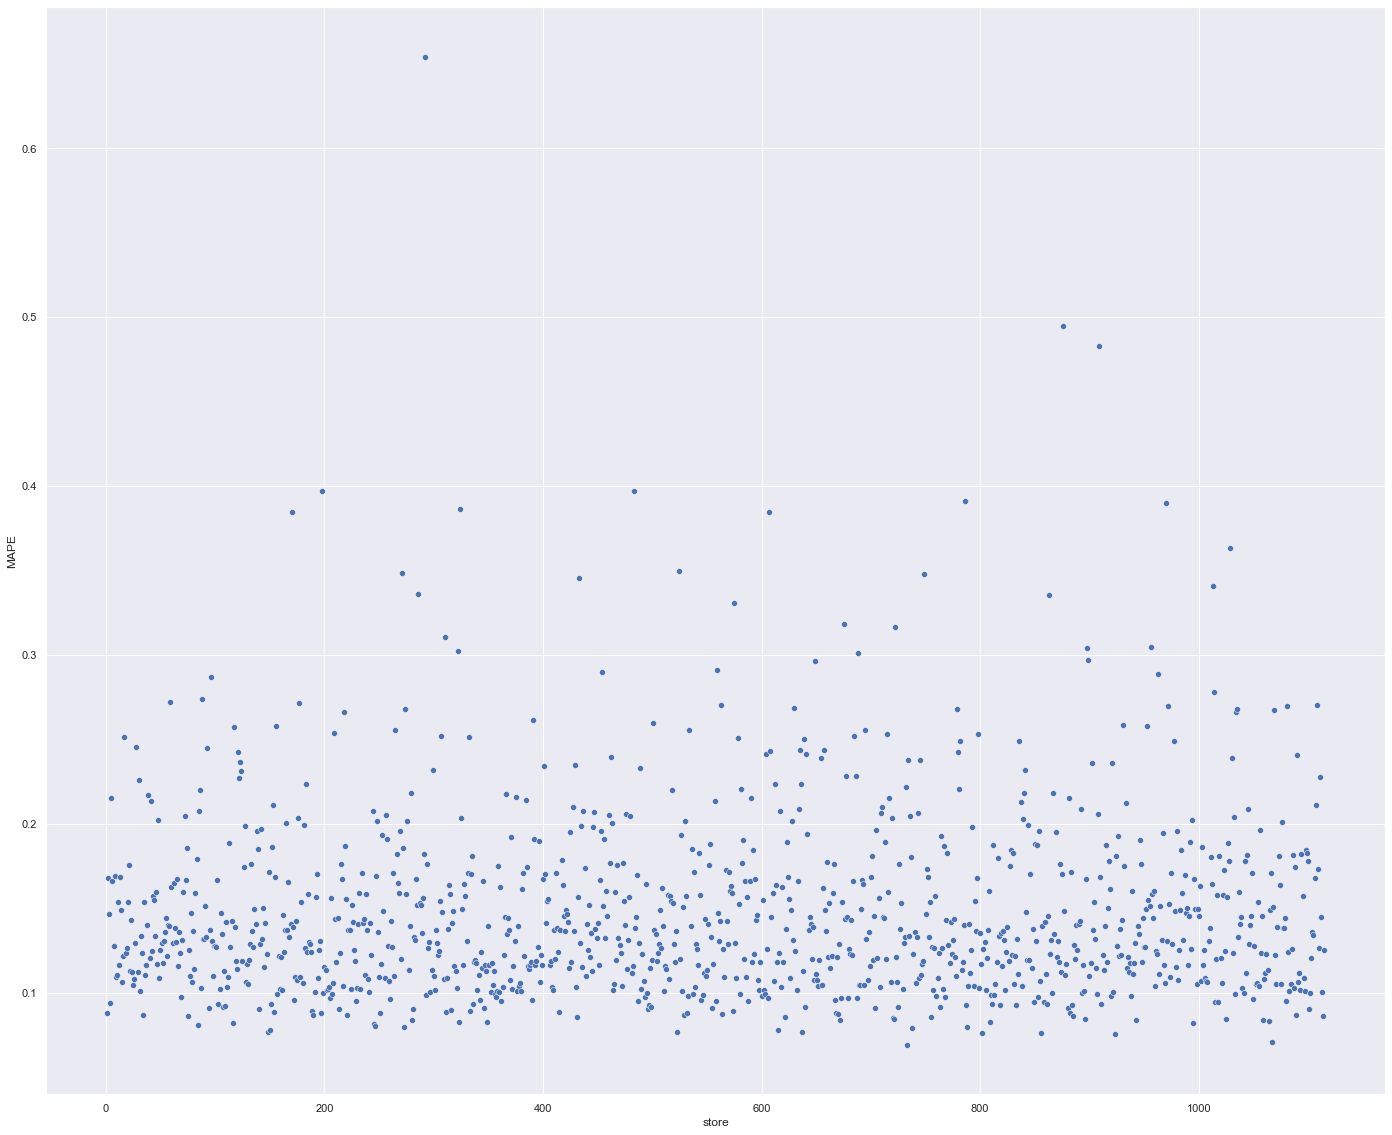

In [83]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [84]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$290,642,432.00"
1,worst_scenario,"R$289,574,532.63"
2,best_scenario,"R$291,710,334.14"


## 9.3. Machine Learning Performance

In [85]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

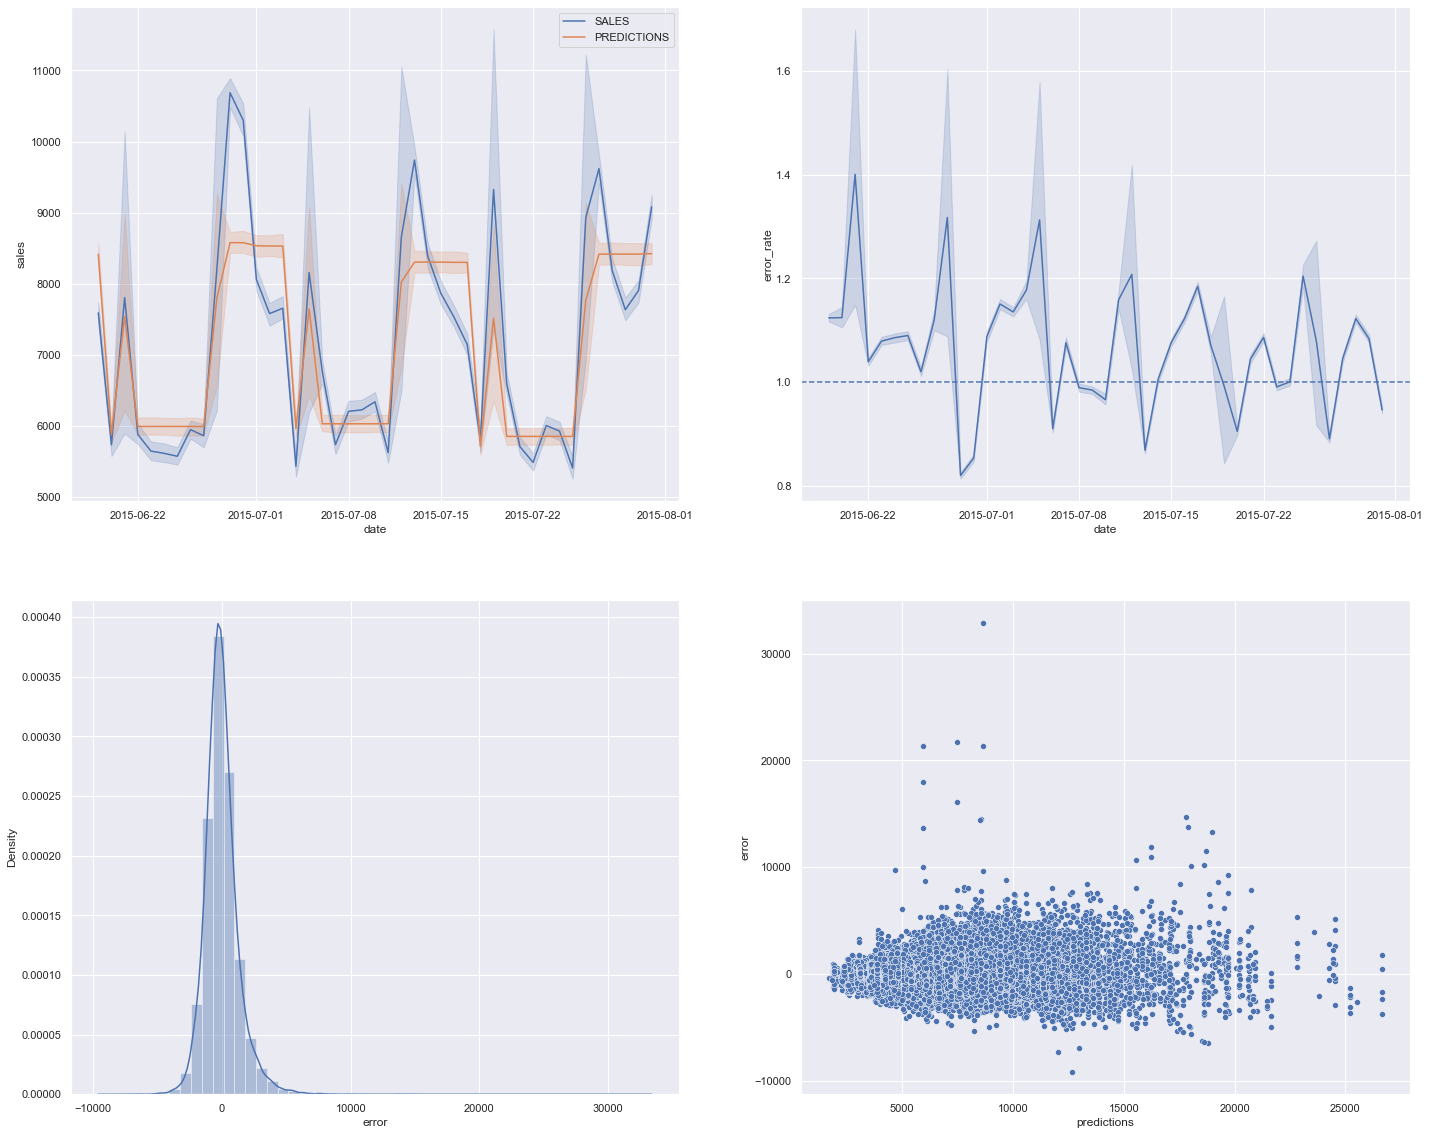

In [86]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 DEPLOY MODEL TO PRODUCTION